In [1]:
import pandas as pd
import re
import numpy as np

# Load the data
customer_regions_df = pd.read_excel('Data/Customer Regions.xlsx')

In [2]:
print("Columns:", customer_regions_df.columns.tolist())

Columns: ['REGION_CODE', 'REGION_DESC']


In [3]:
print("Sample data:\n", customer_regions_df.head())

Sample data:
   REGION_CODE           REGION_DESC
0         000               Unknown
1         10a                Durban
2         10b              Midlands
3         11a  Free State / Lesotho
4         11b  Ermelo / Piet Retief


In [4]:
print("Null values:\n", customer_regions_df.isnull().sum())

Null values:
 REGION_CODE    0
REGION_DESC    0
dtype: int64


In [5]:
# Remove rows with any null values
customer_regions_df_clean = customer_regions_df.dropna()

In [6]:
print("Cleaned data shape:", customer_regions_df_clean.shape)

Cleaned data shape: (34, 2)


In [7]:
#Read the JSON file of the cleaned customer dataframe from customer_data_cleaned.ipynb
customer_df = pd.read_json("customer_df_clean.json", lines=True)

In [8]:
#Manual identification of the invalid region descriptions (REGION_DESC that do not make sense in the context of the Customer Regions table)
#THIS "~" is to EXCLUDE the invalid region descriptions and their corresponding region codes from the dataframe
invalid_labels = [
    "Unknown", "Samples", "ADAPRO", "Stock - Defectives", "Closed - Bad Debts",
    "Closed", "CONS", "Stores", "House Accounts", "Reps Trip - Botswana"
]
customer_regions_df_clean = customer_regions_df_clean[
    ~customer_regions_df_clean['REGION_DESC'].isin(invalid_labels)
    
]

In [9]:
# Identify rows in customer_df where REGION_CODE is NOT found in the reference of the validated customer_regions table
invalid_regions = ~customer_df['REGION_CODE'].isin(customer_regions_df_clean['REGION_CODE'])

# Display those invalid rows
customer_df[invalid_regions]

,CUSTOMER_NUMBER,CCAT_CODE,REGION_CODE,REP_CODE,SETTLE_TERMS,NORMAL_PAYTERMS,DISCOUNT,CREDIT_LIMIT
0,AACJ01,21,25b,ZZZ5,0,90,0,999999
2,AAVN01,21,25b,ZZZ5,0,120,0,500
7,ABLA01,21,25b,ZZZ5,0,120,0,3000
8,ABLE01,21,25b,ZZZ,0,120,0,500
12,ACHD01,21,25b,ZZZ5,0,120,0,2000
...,...,...,...,...,...,...,...,...
1977,YROA14,13,9a,SAMPL,0,30,0,999999
1979,YSTL01,20,25a,ZZZP,0,120,0,10000
1982,YSTL04,21,25b,ZZZ5,0,120,0,10000
1987,ZDOE02,21,25b,ZZZ5,0,120,0,999999


In [10]:
# Keep only rows with valid region codes
customer_df_valid = customer_df[customer_df['REGION_CODE'].isin(customer_regions_df_clean['REGION_CODE'])]

# Merge to add region descriptions; basically acts like a JOIN in SQL
customer_df_valid = customer_df_valid.merge(
    customer_regions_df_clean[['REGION_CODE', 'REGION_DESC']],
    how='left',
    on='REGION_CODE'
)

#Display the updated customer data with VALID region codes and descriptions
customer_df_valid

,CUSTOMER_NUMBER,CCAT_CODE,REGION_CODE,REP_CODE,SETTLE_TERMS,NORMAL_PAYTERMS,DISCOUNT,CREDIT_LIMIT,REGION_DESC
0,AAMI01,41,10a,02,0,120,0,2000,Durban
1,ABHG01,49,10a,02,0,120,0,1500,Durban
2,ABHG02,39,6a,04,0,120,0,2500,East Cape
3,ABHN01,49,10a,02,0,120,0,1500,Durban
4,ABHN02,41,10a,02,0,30,0,500,Durban
...,...,...,...,...,...,...,...,...,...
1265,ZDOE01,30,7a,05,0,120,0,10000,Gauteng N - Sandton
1266,ZHAY02,19,4b,03,0,120,0,2000,Nelspruit / Tzaneen
1267,ZMAU01,37,11a,03,0,120,0,0,Free State / Lesotho
1268,ZNAE01,46,2b,05,0,120,0,30000,Krugersdorp / Sun City


In [11]:
#Export to a JSON format so that it can be used in further cleaning and validation
customer_df_valid.to_json("customer_valid_regions_df.json", orient="records", lines=True)

#Export to CSV format for easier readability
customer_df_valid.to_csv("customer_valid_regions_clean.csv", index=False)

<Axes: ylabel='REGION_DESC'>

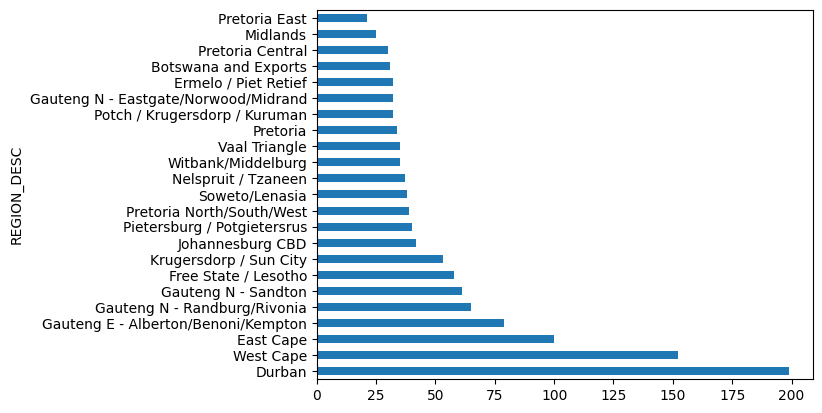

In [12]:
import matplotlib

customer_df_valid['REGION_DESC'].value_counts().plot(kind='barh')

In [13]:
code_to_desc = customer_regions_df_clean.set_index('REGION_CODE')['REGION_DESC'].to_dict()
top_codes = customer_df_valid['REGION_CODE'].value_counts().head(10)

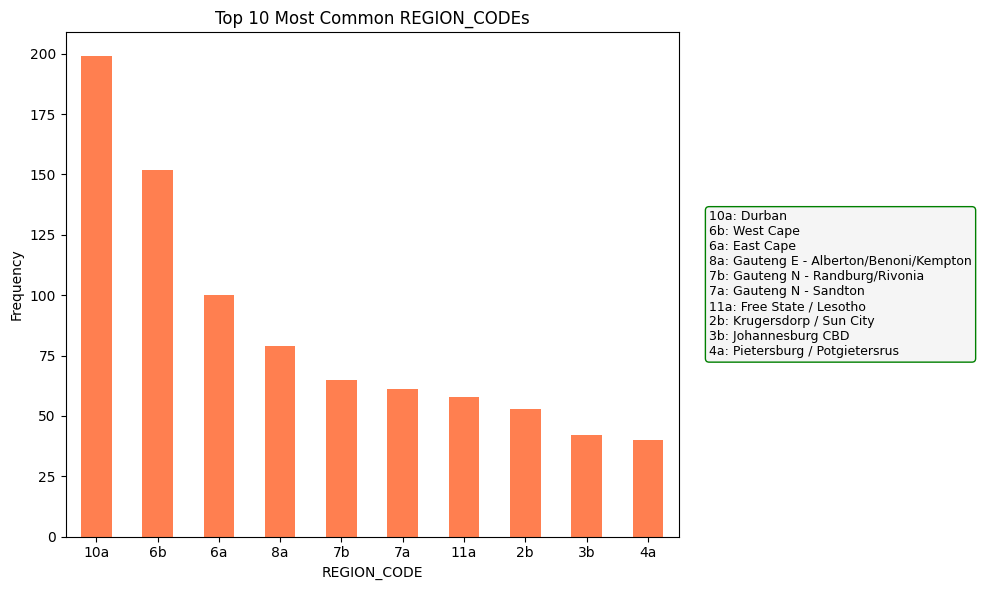

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
top_codes.plot(kind='bar', color='coral', ax=ax)

plt.title("Top 10 Most Common REGION_CODEs")
plt.xlabel("REGION_CODE")
plt.ylabel("Frequency")
plt.xticks(rotation=0)

# Create legend text
legend_text = "\n".join([f"{code}: {code_to_desc.get(code, 'Unknown')}" for code in top_codes.index])

# Add legend box to the side
props = dict(boxstyle='round', facecolor='whitesmoke', edgecolor='green')

# Position the legend box outside the plot area
ax.text(1.05, 0.5, legend_text, transform=ax.transAxes,
        fontsize=9, verticalalignment='center', bbox=props)

plt.tight_layout()
plt.show()